In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# If on colab, clone the git repo
!git clone https://github.com/vandrearczyk/isc-example-yolo.git

In [3]:
from pathlib import Path
Path("../models").mkdir(parents=True, exist_ok=True)

In [5]:
!wget -O ../models/yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2024-06-21 10:37:51--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘../models/yolov3.weights’

../models/yolov3.we 100%[===================>] 236.52M  1.11MB/s    in 2m 30s  

2024-06-21 10:40:47 (1.58 MB/s) - ‘../models/yolov3.weights’ saved [248007048/248007048]



In [6]:
# Load YOLO
net = cv2.dnn.readNet("../models/yolov3.weights", "../cfg/yolov3.cfg")
classes = []
with open("../data/labels/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
print('Number of classes:', len(classes))

layer_names = net.getLayerNames()
output_layers_indices = [i - 1 for i in net.getUnconnectedOutLayers()]
output_layers = [layer_names[i] for i in output_layers_indices]

print("Output layers:", output_layers)

Number of classes: 80
Output layers: ['yolo_82', 'yolo_94', 'yolo_106']


person: 1
person: 7
person: 8
person: 15
person: 17
person: 25
person: 27


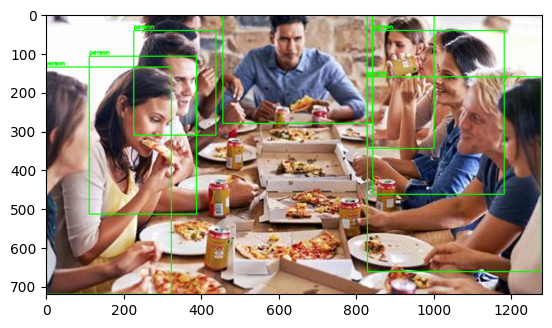

Total number of person detected: 7


In [8]:
# Load image
img = cv2.imread("../data/pizza1.jpg")
height, width, channels = img.shape

# Preprocess image for YOLO
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Define class to detect
object_class = "person"

confidences = []
boxes = []
class_ids = []  # Store class_ids for the detected objects
detection_count = 0  # Counter for the number of objects detected

# Process detections
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Adjust confidence threshold as needed
            # Check if the detected object is of the defined class
            if classes[class_id] == object_class:
                # Draw bounding box and label for all objects
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)  # Store the class_id

# Non-maximum suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

for i in range(len(boxes)):
    if i in indices:
        print(f'{object_class}: {i}')
        detection_count += 1

        [x, y, w, h] = boxes[i]
        confidence = confidences[i]

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, classes[class_ids[i]], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes and labels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Print the total number of objects detected
print(f"Total number of {object_class} detected: {detection_count}")